In [4]:
#Loads core libraries (pandas, numpy, matplotlib, geopandas, etc.) that enable data manipulation, visualization, and spatial analysis. 
#!pip install fiona
import matplotlib.pyplot as plt
from pathlib import Path
import os
from shapely.geometry import box
from pyogrio import list_layers
import geopandas as gpd
import fiona
from shapely.ops import unary_union
from shapely.geometry import GeometryCollection
import rasterio
import numpy as np
import rasterio
from rasterio.mask import mask

In [5]:
#Reads the CSV or Excel dataset containing discharge, temperature, or water chemistry observations. 
#Creates a base DataFrame for all subsequent cleaning and analysis steps.
PROJECT = Path.cwd() 
for d in ["data_raw", "data_processed", "outputs", "docs"]:
    (PROJECT / d).mkdir(exist_ok=True)

print("Project root:", PROJECT)


Project root: C:\Users\Rbrig\fossil_creek_project


In [6]:


TARGET_CRS = "EPSG:26912"  # NAD83 / UTM Zone 12N (good for AZ)


In [7]:


data_raw = Path("data_raw")
for p in data_raw.glob("*"):
    print("-", p.name)


- BackboneFire_2021.zip
- BackboneFire_2021_empty.zip
- Backbone_Postfire_20210811
- Backbone_preFire_20210523
- WBD_15_HU2_GDB.gdb
- WBD_HU10_AZ.zip


In [8]:

gdb = Path("data_raw/WBD_15_HU2_GDB.gdb")
print([l[0] for l in list_layers(gdb)])  # list all layers
wbd = gpd.read_file(gdb, layer="WBDHU10")
print(len(wbd), "features loaded")
wbd.head()


['ExternalCrosswalk', 'FeatureToMetadata', 'HUMod', 'MetaProcessDetail', 'MetaSourceDetail', 'ProcessingParameters', 'UpdateStatus', 'WBDLine', 'WBDHU8', 'WBDHU6', 'WBDHU4', 'WBDHU2', 'WBDHU16', 'WBDHU14', 'WBDHU12', 'WBDHU10', 'NonContributingDrainageLine', 'NonContributingDrainageArea', 'NWISDrainageLine', 'NWISDrainageArea', 'CLIPPOLY']
630 features loaded


,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,referencegnis_ids,areaacres,areasqkm,states,huc10,name,hutype,humod,shape_Length,shape_Area,geometry
0,{09C180F1-1C3A-46CA-9F26-486D5446C729},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,2024-08-15 13:01:21+00:00,"9911,42838",297146.33,1202.51,"AZ,NM",1504000207,Railroad Wash-Gila River,S,None,1.847908,0.115569,"MULTIPOLYGON (((-108.95124 32.88512, -108.9511..."
1,{B4051682-6DD1-490F-843A-1063B3DF4808},{511D2AC8-11BA-45FC-AB98-F69D693D4C44},Watershed Boundary Dataset (WBD),Natural Resources and Conservation Service and...,None,2024-08-15 13:01:21+00:00,1500,225564.45,912.83,"AZ,NM",1502000606,Lower Black Creek,S,None,1.887737,0.090723,"MULTIPOLYGON (((-108.92848 35.75135, -108.9282..."
2,{3798DBC6-1378-5150-E054-0021286F9DF6},{1809B4AF-E65B-4679-8AE5-16FA1BA7E7A4},{1809B4AF-E65B-4679-8AE5-16FA1BA7E7A4},None,None,2012-10-24 07:27:19+00:00,None,149443.66,604.78,"AZ,MX",1508020024,Headwaters Rio El Sasabe,S,NM,2.376763,0.057302,"MULTIPOLYGON (((-111.57608 31.53927, -111.5760..."
3,{3798DBC6-132C-5150-E054-0021286F9DF6},{1809B4AF-E65B-4679-8AE5-16FA1BA7E7A4},{1809B4AF-E65B-4679-8AE5-16FA1BA7E7A4},None,None,2012-10-24 07:27:19+00:00,None,181025.35,732.58,"AZ,MX",1508010109,Rio San Francisquito,S,NM,1.329031,0.069600,"MULTIPOLYGON (((-112.07755 31.50166, -112.0774..."
4,{3798DBC6-127E-5150-E054-0021286F9DF6},{1809B4AF-E65B-4679-8AE5-16FA1BA7E7A4},{1809B4AF-E65B-4679-8AE5-16FA1BA7E7A4},None,None,2012-10-24 07:27:20+00:00,None,88485.35,358.09,"AZ,MX",1508010302,Puentes Cuates,C,NC,1.331584,0.034228,"MULTIPOLYGON (((-113.86067 32.29242, -113.8605..."


In [9]:


TARGET_CRS = "EPSG:26912"  # NAD83 / UTM Zone 12N (good for central AZ)

# If your GeoDataFrame is named wbd:
print("Original CRS:", wbd.crs)
wbd = wbd.to_crs(TARGET_CRS)

# keep only AZ features (states field like 'AZ,NM', 'AZ,MX', etc.)
wbd_az = wbd[wbd["states"].str.contains(r"\bAZ\b", na=False)]
print("AZ HU10 count:", len(wbd_az))


Original CRS: EPSG:4269
AZ HU10 count: 445


In [10]:


cands = wbd_az[wbd_az["name"].str.contains("Fossil", case=False, na=False)]
cands[["huc10", "name", "areasqkm"]]


,huc10,name,areasqkm
580,1506020303,Fossil Creek-Verde River,775.39


In [11]:


fossil = wbd_az[wbd_az["huc10"] == "1506020303"].copy()
fossil = fossil.explode(index_parts=False).reset_index(drop=True)
fossil["geometry"] = fossil.buffer(0)

out = Path("data_processed/FossilCreek_WBD_HU10.shp")
out.parent.mkdir(parents=True, exist_ok=True)
fossil.to_file(out)
print("AOI shapefile saved to:", out)


AOI shapefile saved to: data_processed\FossilCreek_WBD_HU10.shp


C:\Users\Rbrig\AppData\Local\Temp\ipykernel_19264\1678944649.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  fossil.to_file(out)
C:\Users\Rbrig\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'metasourceid' to 'metasource'
  ogr_write(
C:\Users\Rbrig\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'sourcedatadesc' to 'sourcedata'
  ogr_write(
C:\Users\Rbrig\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'sourceoriginator' to 'sourceorig'
  ogr_write(
C:\Users\Rbrig\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'sourcefeatureid' to 'sourcefeat'
  ogr_write(
C:\Users\Rbrig\AppData\Local\Programs\Python\Python313\Lib

In [12]:

# If the kernel was restarted and 'fossil' isn't in memory, re-load it:
# fossil = gpd.read_file("data_processed/FossilCreek_WBD_HU10.shp").to_crs("EPSG:26912")

keep = ["huc10", "name", "states", "areasqkm", "geometry"]
fossil_clean = fossil[keep].copy()

# 1) GeoPackage (preferred)
gpkg = Path("data_processed/FossilCreek_AOI.gpkg")
fossil_clean.to_file(gpkg, layer="aoi", driver="GPKG")

# 2) GeoJSON (handy for web)
geojson = Path("data_processed/FossilCreek_AOI.geojson")
fossil_clean.to_file(geojson, driver="GeoJSON")

print("Wrote:", gpkg, "and", geojson)


Wrote: data_processed\FossilCreek_AOI.gpkg and data_processed\FossilCreek_AOI.geojson


In [13]:

aoi = gpd.read_file("data_processed/FossilCreek_AOI.gpkg", layer="aoi")
print(aoi.dtypes)   # full field names preserved
print(aoi.crs)      # should be EPSG:26912
aoi.head()


huc10         object
name          object
states        object
areasqkm     float64
geometry    geometry
dtype: object
EPSG:26912


,huc10,name,states,areasqkm,geometry
0,1506020303,Fossil Creek-Verde River,AZ,775.39,"POLYGON ((427520.504 3827711.486, 427519.306 3..."


In [14]:


for p in Path("data_raw").glob("BackboneFire_2021*.zip"):
    print("-", p.name, "size:", round(p.stat().st_size/1e6,2), "MB")


- BackboneFire_2021.zip size: 0.16 MB
- BackboneFire_2021_empty.zip size: 0.04 MB


In [15]:


fire_zip = Path("data_raw/BackboneFire_2021.zip")
print("Layers inside ZIP:")
print(fiona.listlayers(f"zip://{fire_zip}"))


Layers inside ZIP:
['Perimeters']


In [16]:

fire_zip = Path("data_raw/BackboneFire_2021.zip")

fire = gpd.read_file(f"zip://{fire_zip}", layer="Perimeters")

print(fire.head())
print("\nGeometry validity:", fire.geometry.is_valid.sum(), "/", len(fire))
print("Empty geometries:", fire.geometry.is_empty.sum(), "/", len(fire))
print("\nBounds:", fire.total_bounds)


   poly_Sourc poly_Incid                     poly_Featu     poly_MapMe  \
0        9176   Backbone  Wildfire Daily Fire Perimeter    Hand Sketch   
1       11327   Backbone  Wildfire Final Fire Perimeter  Mixed Methods   
2       21076   Backbone  Wildfire Final Fire Perimeter    Hand Sketch   
3       35685   Backbone  Wildfire Daily Fire Perimeter  Mixed Methods   
4       47188   Backbone  Wildfire Daily Fire Perimeter  Mixed Methods   

     poly_GISAc poly_Delet poly_Fea_1 poly_Fea_2 poly_IsVis poly_Creat  ...  \
0      0.000000         No     Public   Approved        Yes 1899-12-30  ...   
1  40858.110000         No     Public   Approved        Yes 1899-12-30  ...   
2      5.000000         No     Public   Approved        Yes 2024-04-30  ...   
3   2408.958498         No     Public   Approved        Yes 2025-08-11  ...   
4   3352.867579         No     Public   Approved        Yes 2025-09-26  ...   

  attr_Cre_1 attr_Mod_1 attr_Sou_1 attr_IsCpx    attr_CpxNa  \
0 2021-04-27 2022

In [17]:
print("rows:", len(fire))
print("crs:", fire.crs)
print("empty geom:", int(fire.geometry.is_empty.sum()), "of", len(fire))
print("total_bounds:", fire.total_bounds)  # [minx, miny, maxx, maxy]


rows: 5
crs: EPSG:4326
empty geom: 0 of 5
total_bounds: [-123.98038495   31.47286425  -92.13321      42.72654613]


In [19]:
#fire_in_aoi[["poly_Incid", "poly_Featu", "poly_GISAc"]]


In [20]:


# Build a single AOI geometry
aoi_union = aoi.geometry.unary_union

# Clip Backbone fire perimeters to the Fossil Creek AOI
fire_in_aoi = fire[fire.geometry.intersects(aoi_union)]

print("Total Backbone features:", len(fire))
print("Backbone features intersecting Fossil Creek AOI:", len(fire_in_aoi))


Total Backbone features: 5
Backbone features intersecting Fossil Creek AOI: 0


C:\Users\Rbrig\AppData\Local\Temp\ipykernel_19264\3052253869.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  aoi_union = aoi.geometry.unary_union


In [21]:
print("AOI CRS:        ", aoi.crs)
print("fire_in_aoi CRS:", fire_in_aoi.crs)


AOI CRS:         EPSG:26912
fire_in_aoi CRS: EPSG:4326


In [22]:
# This cell rebuilds the Backbone Fire perimeter subset that overlaps Fossil Creek AOI.
# It creates `fire_in_aoi` in the SAME CRS (EPSG:26912) as your AOI.

# --- Load AOI in projected CRS (UTM 12N) ---
aoi = gpd.read_file("data_processed/FossilCreek_AOI.gpkg", layer="aoi")
aoi = aoi.to_crs("EPSG:26912")      # stay in a projected CRS for area calculations

print("AOI CRS:", aoi.crs)

# --- Load Backbone fire perimeter file ---
fire_zip = Path("data_raw/BackboneFire_2021.zip")
fire_all = gpd.read_file(f"zip://{fire_zip}", layer="Perimeters")

print("Fire CRS (original):", fire_all.crs)
print("Total features in file:", len(fire_all))

# If it comes in as WGS84, project it to match the AOI
if fire_all.crs is None:
    fire_all = fire_all.set_crs("EPSG:4326")

fire_all = fire_all.to_crs(aoi.crs)   # now both are EPSG:26912

# --- OPTIONAL: inspect incident names so we know what to filter on ---
print("Unique incident names (poly_Incid):")
print(sorted(fire_all["poly_Incid"].unique()))

# --- Keep only the Backbone incident (and optionally the final perimeter) ---
fire_backbone = fire_all[fire_all["poly_Incid"] == "Backbone"].copy()

# If you want only the final fire perimeter, uncomment this line:
# fire_backbone = fire_backbone[fire_backbone["poly_Featu"] == "Wildfire Final Fire Perimeter"].copy()

print("Backbone features (all perimeters):", len(fire_backbone))

# --- Intersect Backbone with Fossil Creek AOI to get just the within-AOI piece ---
aoi_union = unary_union(aoi.geometry)
fire_in_aoi = fire_backbone[fire_backbone.geometry.intersects(aoi_union)].copy()

print("fire_in_aoi rows (Backbone overlapping Fossil Creek):", len(fire_in_aoi))
print("fire_in_aoi bounds:", fire_in_aoi.total_bounds)


AOI CRS: EPSG:26912
Fire CRS (original): EPSG:4326
Total features in file: 5
Unique incident names (poly_Incid):
['Backbone']
Backbone features (all perimeters): 5
fire_in_aoi rows (Backbone overlapping Fossil Creek): 1
fire_in_aoi bounds: [ 436425.2526296  3807483.70303576  439589.96753886 3811251.28335658]


Intersection geom type: GeometryCollection
Intersection area (m²): 4442527.776283006
Intersection area (km²): 4.442527776283006
AOI area: 774.85 km²
Burned within AOI: 4.44 km² (0.57%)
Saved: data_processed\FossilCreek_Backbone_AOI.gpkg


<Axes: >

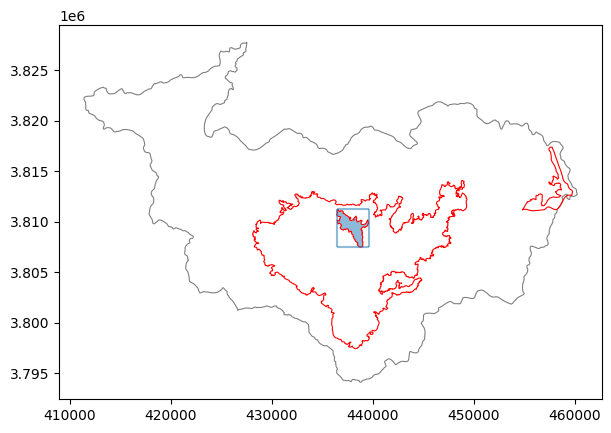

In [23]:
# This cell manually intersects the Backbone fire perimeter with the Fossil Creek AOI
# and computes burned area stats. It avoids the buffer(0)+overlay issue.

from shapely.ops import unary_union
from shapely.geometry import GeometryCollection
import geopandas as gpd
from pathlib import Path

# 1. Build a single AOI geometry (we're already in EPSG:26912)
aoi_union = unary_union(aoi.geometry)

# 2. Raw intersection between the Backbone fire and AOI
raw_intersection = fire_in_aoi.geometry.iloc[0].intersection(aoi_union)

print("Intersection geom type:", raw_intersection.geom_type)
print("Intersection area (m²):", raw_intersection.area)
print("Intersection area (km²):", raw_intersection.area / 1e6)

# 3. Explode GeometryCollection into individual polygons
if isinstance(raw_intersection, GeometryCollection):
    geoms = [g for g in raw_intersection.geoms if not g.is_empty]
else:
    geoms = [raw_intersection]

# 4. Build GeoDataFrame for burned area inside the AOI
aoi_fire = gpd.GeoDataFrame(
    {
        "huc10": [aoi["huc10"].iloc[0]] * len(geoms),
        "name": [aoi["name"].iloc[0]] * len(geoms),
    },
    geometry=geoms,
    crs=aoi.crs,
)

# 5. Area stats (m² → km²)
aoi_area_km2 = aoi.geometry.area.sum() / 1e6
burn_km2 = aoi_fire.geometry.area.sum() / 1e6
pct = (burn_km2 / aoi_area_km2) * 100 if aoi_area_km2 > 0 else 0

print(f"AOI area: {aoi_area_km2:.2f} km²")
print(f"Burned within AOI: {burn_km2:.2f} km² ({pct:.2f}%)")

# 6. Save result
out = Path("data_processed/FossilCreek_Backbone_AOI.gpkg")
aoi_fire.to_file(out, layer="aoi_fire", driver="GPKG")
print("Saved:", out)

# 7. Quick visual check
ax = aoi.boundary.plot(figsize=(7, 6), linewidth=0.8, color="gray")
fire_in_aoi.boundary.plot(ax=ax, linewidth=0.8, color="red")
aoi_fire.plot(ax=ax, alpha=0.5)


In [24]:
print(len(fire_in_aoi))
fire_in_aoi.head()


1


,poly_Sourc,poly_Incid,poly_Featu,poly_MapMe,poly_GISAc,poly_Delet,poly_Fea_1,poly_Fea_2,poly_IsVis,poly_Creat,...,attr_Cre_1,attr_Mod_1,attr_Sou_1,attr_IsCpx,attr_CpxNa,attr_CpxID,attr_Sou_2,GlobalID,attr_Inc_6,geometry
1,11327,Backbone,Wildfire Final Fire Perimeter,Mixed Methods,40858.11,No,Public,Approved,Yes,1899-12-30,...,2021-06-17,2021-09-22,FODR,0,None,None,{558D2E70-2E55-4F06-87D3-7BB3A58A0933},3e6150ae-1303-4057-b7b2-b7f6011cbde1,None,"POLYGON ((438863.039 3809286.731, 438820.869 3..."


In [25]:
print("len(fire_in_aoi):", len(fire_in_aoi))
print("CRS fire_in_aoi:", fire_in_aoi.crs)
print("geom type:", fire_in_aoi.geometry.geom_type.values)
print("is_valid:", fire_in_aoi.geometry.is_valid.values)
print("is_empty:", fire_in_aoi.geometry.is_empty.values)
print("bounds fire_in_aoi:", fire_in_aoi.total_bounds)
print("bounds AOI:", aoi.total_bounds)


len(fire_in_aoi): 1
CRS fire_in_aoi: EPSG:26912
geom type: ['Polygon']
is_valid: [False]
is_empty: [False]
bounds fire_in_aoi: [ 436425.2526296  3807483.70303576  439589.96753886 3811251.28335658]
bounds AOI: [ 411390.3621762  3794119.25089371  460233.42939826 3827802.72824166]


In [26]:

aoi_union = unary_union(aoi.geometry)

raw_intersection = fire_in_aoi.geometry.iloc[0].intersection(aoi_union)
print("Intersection geom type:", raw_intersection.geom_type)
print("Intersection area (m²):", raw_intersection.area)
print("Intersection area (km²):", raw_intersection.area / 1e6)


Intersection geom type: GeometryCollection
Intersection area (m²): 4442527.776283006
Intersection area (km²): 4.442527776283006


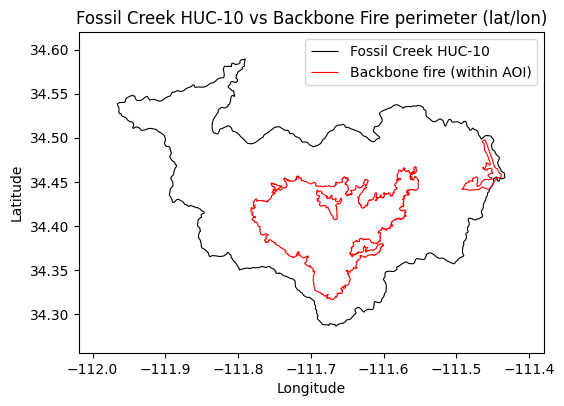

In [27]:
# This cell reprojects AOI and ONLY the Backbone perimeter that overlaps Fossil Creek
# and plots them together, zoomed around the AOI.

# AOI in lat/lon
aoi_ll = aoi.to_crs("EPSG:4326")

# Backbone *within AOI* in lat/lon
fire_aoi_ll = fire_in_aoi.to_crs("EPSG:4326")

fig, ax = plt.subplots(figsize=(6, 6))
aoi_ll.boundary.plot(ax=ax, linewidth=0.8, color="black", label="Fossil Creek HUC-10")
fire_aoi_ll.boundary.plot(ax=ax, linewidth=0.8, color="red", label="Backbone fire (within AOI)")

# Zoom to AOI extent with a small buffer
minx, miny, maxx, maxy = aoi_ll.total_bounds
pad_x = (maxx - minx) * 0.1
pad_y = (maxy - miny) * 0.1
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Fossil Creek HUC-10 vs Backbone Fire perimeter (lat/lon)")
ax.legend()

plt.show()


Intersection type: GeometryCollection
AOI area: 774.85 km²
Burned within AOI: 4.44 km² (0.57%)
Saved: data_processed\FossilCreek_Backbone_AOI.gpkg


<Axes: >

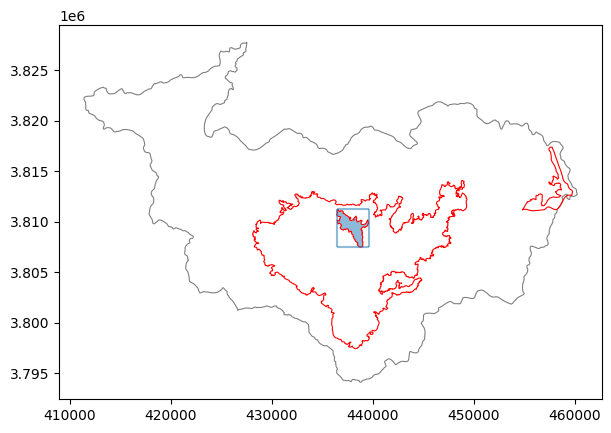

In [28]:

# 1. AOI union and raw intersection (you already computed these, but it's safe to recompute)
aoi_union = unary_union(aoi.geometry)
raw_intersection = fire_in_aoi.geometry.iloc[0].intersection(aoi_union)

print("Intersection type:", raw_intersection.geom_type)

# 2. Explode GeometryCollection into individual polygons
if isinstance(raw_intersection, GeometryCollection):
    geoms = [g for g in raw_intersection.geoms if not g.is_empty]
else:
    geoms = [raw_intersection]

# 3. Build a GeoDataFrame for the burned area inside the AOI
aoi_fire = gpd.GeoDataFrame(
    {
        "huc10": [aoi["huc10"].iloc[0]] * len(geoms),
        "name": [aoi["name"].iloc[0]] * len(geoms),
    },
    geometry=geoms,
    crs=aoi.crs,
)

# 4. Area stats
aoi_area_km2 = aoi.geometry.area.sum() / 1e6
burn_km2 = aoi_fire.geometry.area.sum() / 1e6
pct = (burn_km2 / aoi_area_km2) * 100

print(f"AOI area: {aoi_area_km2:.2f} km²")
print(f"Burned within AOI: {burn_km2:.2f} km² ({pct:.2f}%)")

# 5. Save result
out = Path("data_processed/FossilCreek_Backbone_AOI.gpkg")
aoi_fire.to_file(out, layer="aoi_fire", driver="GPKG")
print("Saved:", out)

# 6. Quick visual check
ax = aoi.boundary.plot(figsize=(7,6), linewidth=0.8, color="gray")
fire_in_aoi.boundary.plot(ax=ax, linewidth=0.8, color="red")
aoi_fire.plot(ax=ax, alpha=0.5)


In [37]:
minx, miny, maxx, maxy = aoi.to_crs("EPSG:4326").total_bounds
print("Bounding box (lat/lon):")
print("Min Lon:", minx)
print("Min Lat:", miny)
print("Max Lon:", maxx)
print("Max Lat:", maxy)


Bounding box (lat/lon):
Min Lon: -111.96563792102222
Min Lat: 34.286463395738906
Max Lon: -111.43293801664078
Max Lat: 34.58947271089357


In [38]:

# This cell loads all renamed pre-fire Landsat 8 surface reflectance bands into memory.
# These bands (Blue, Green, Red, NIR, SWIR1, SWIR2 + QA mask) are required for computing NDVI, NBR, and for cloud masking.

# Folder containing the renamed pre-fire Landsat files
pf_dir = Path("data_raw/Backbone_preFire_20210523")

# Open each spectral band
b2 = rasterio.open(pf_dir / "Prefire_B2_Blue.TIF")     # Blue
b3 = rasterio.open(pf_dir / "Prefire_B3_Green.TIF")    # Green
b4 = rasterio.open(pf_dir / "Prefire_B4_Red.TIF")      # Red
b5 = rasterio.open(pf_dir / "Prefire_B5_NIR.TIF")      # NIR
b6 = rasterio.open(pf_dir / "Prefire_B6_SWIR1.TIF")    # SWIR1
b7 = rasterio.open(pf_dir / "Prefire_B7_SWIR2.TIF")    # SWIR2

qa = rasterio.open(pf_dir / "Prefire_QA_PIXEL.TIF")    # Pixel quality mask

print("Loaded bands successfully!")
print("CRS:", b4.crs)
print("Shape:", b4.read(1).shape)

Loaded bands successfully!
CRS: EPSG:32612
Shape: (7881, 7751)


In [39]:
# This cell loads the Fossil Creek AOI and reprojects it so it lines up with the Landsat pre-fire image (same CRS as B4).
import geopandas as gpd
from shapely.ops import unary_union

aoi = gpd.read_file("data_processed/FossilCreek_AOI.gpkg", layer="aoi")
aoi_utm = aoi.to_crs(b4.crs)      # match EPSG:32612 from the Landsat bands
aoi_geom = [unary_union(aoi_utm.geometry)]

print("AOI CRS:", aoi_utm.crs)
print("AOI polygon count:", len(aoi_utm))


AOI CRS: PROJCS["WGS 84 / UTM zone 12N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32612"]]
AOI polygon count: 1


In [40]:
# This cell clips the pre-fire Landsat bands and QA image down to just your Fossil Creek AOI so we only process the study area.
import numpy as np
from rasterio.mask import mask

def clip_band(src, shapes):
    data, transform = mask(src, shapes, crop=True)
    return data[0], transform

red, out_transform = clip_band(b4, aoi_geom)    # Band 4 (red)
nir, _           = clip_band(b5, aoi_geom)      # Band 5 (NIR)
swir2, _         = clip_band(b7, aoi_geom)      # Band 7 (SWIR2)
qa_clip, _       = clip_band(qa, aoi_geom)      # QA_PIXEL

print("Clipped shape (rows, cols):", red.shape)


Clipped shape (rows, cols): (1123, 1629)


In [41]:
# This cell uses the QA_PIXEL band to keep only clear pixels (no clouds/shadows), following the standard 'lower 5 bits == 0' rule.
# That gives us a boolean mask we can apply to NDVI/NBR later so cloud-contaminated pixels don’t mess up the fire analysis.
clear_mask = (qa_clip & int('11111', 2)) == 0   # bits 0–4 all zero => clear conditions

print("Total pixels:", qa_clip.size)
print("Clear pixels:", int(clear_mask.sum()))
print("Percent clear: {:.1f}%".format(100 * clear_mask.sum() / qa_clip.size))


Total pixels: 1829367
Clear pixels: 1829319
Percent clear: 100.0%


In [42]:
# This cell applies the Landsat Collection-2 scale factors to convert raw DN values to reflectance.
# Landsat documentation: SR = DN * 0.0000275 - 0.2

scale = 0.0000275
offset = -0.2

red_sr  = red.astype("float32")  * scale + offset
nir_sr  = nir.astype("float32")  * scale + offset
swir2_sr = swir2.astype("float32") * scale + offset

print("Scaled reflectance ranges:")
print("RED:",  np.nanmin(red_sr),  np.nanmax(red_sr))
print("NIR:",  np.nanmin(nir_sr),  np.nanmax(nir_sr))
print("SWIR2:", np.nanmin(swir2_sr), np.nanmax(swir2_sr))


Scaled reflectance ranges:
RED: -0.2 0.50048
NIR: -0.2 0.54769754
SWIR2: -0.2 0.74712753


In [43]:
# This cell recomputes NDVI and NBR using real reflectance values (scaled),
# applying the clear-sky mask so cloud pixels are excluded.

ndvi_denom = (nir_sr + red_sr)
nbr_denom  = (nir_sr + swir2_sr)

ndvi = np.where(
    clear_mask & (ndvi_denom != 0),
    (nir_sr - red_sr) / ndvi_denom,
    np.nan
)

nbr = np.where(
    clear_mask & (nbr_denom != 0),
    (nir_sr - swir2_sr) / nbr_denom,
    np.nan
)

print("NDVI stats:", np.nanmin(ndvi), np.nanmax(ndvi))
print("NBR  stats:", np.nanmin(nbr),  np.nanmax(nbr))


NDVI stats: -2.2367363 0.92744106
NBR  stats: -2.5720663 0.8185096


In [44]:
#clips NDVI and NBR to the physically realistic range of −1 to 1 and prints summary stats, don’t carry extreme values into later analysis.
# Clip NDVI and NBR to [-1, 1] to enforce physical limits
ndvi_clipped = np.clip(ndvi, -1.0, 1.0)
nbr_clipped  = np.clip(nbr, -1.0, 1.0)

print("NDVI (clipped) stats: min={:.3f}, max={:.3f}".format(
    np.nanmin(ndvi_clipped), np.nanmax(ndvi_clipped)))
print("NBR  (clipped) stats: min={:.3f}, max={:.3f}".format(
    np.nanmin(nbr_clipped), np.nanmax(nbr_clipped)))


NDVI (clipped) stats: min=-1.000, max=0.927
NBR  (clipped) stats: min=-1.000, max=0.819


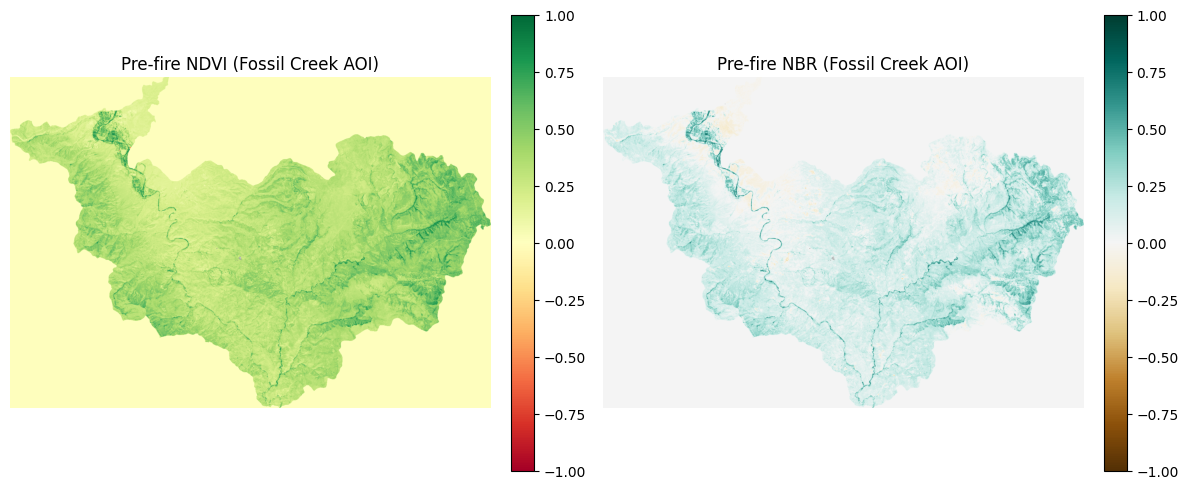

In [45]:
#This cell makes simple map plots of the clipped NDVI and NBR so you can visually confirm vegetation and burn-sensitivity patterns over the AOI
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(ndvi_clipped, cmap="RdYlGn", vmin=-1, vmax=1)
axes[0].set_title("Pre-fire NDVI (Fossil Creek AOI)")
axes[0].axis("off")
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(nbr_clipped, cmap="BrBG", vmin=-1, vmax=1)
axes[1].set_title("Pre-fire NBR (Fossil Creek AOI)")
axes[1].axis("off")
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [46]:
#writes the pre-fire NDVI and NBR arrays out as GeoTIFF rasters in data_processed, 
#using the Landsat CRS/transform, so you can reuse them later, bring them into QGIS/ArcGIS, and reference them in your final products.

out_dir = Path("data_processed")
out_dir.mkdir(exist_ok=True)

# Start from the original band 4 profile and update for our derived rasters
profile = b4.profile.copy()
profile.update(
    driver="GTiff",
    height=ndvi_clipped.shape[0],
    width=ndvi_clipped.shape[1],
    transform=out_transform,   # from your earlier clip step
    count=1,
    dtype="float32",
    nodata=np.nan
)

ndvi_path = out_dir / "FossilCreek_prefire_NDVI.tif"
nbr_path  = out_dir / "FossilCreek_prefire_NBR.tif"

with rasterio.open(ndvi_path, "w", **profile) as dst:
    dst.write(ndvi_clipped.astype("float32"), 1)

with rasterio.open(nbr_path, "w", **profile) as dst:
    dst.write(nbr_clipped.astype("float32"), 1)

print("Saved pre-fire NDVI to:", ndvi_path)
print("Saved pre-fire NBR  to:", nbr_path)


Saved pre-fire NDVI to: data_processed\FossilCreek_prefire_NDVI.tif
Saved pre-fire NBR  to: data_processed\FossilCreek_prefire_NBR.tif


In [47]:
#opens your post-fire Landsat bands and QA layer from the renamed files and prints out the CRS and array shape 
#so we can confirm they match the pre-fire scene (EPSG:32612 and similar dimensions).

# Folder containing the renamed *post-fire* Landsat files
pf_post_dir = Path("data_raw/Backbone_postFire_20210811")

# Open each spectral band (make sure names match your folder)
post_b2 = rasterio.open(pf_post_dir / "Postfire_B2_Blue.TIF")     # Blue
post_b3 = rasterio.open(pf_post_dir / "Postfire_B3_Green.TIF")    # Green
post_b4 = rasterio.open(pf_post_dir / "Postfire_B4_Red.TIF")      # Red
post_b5 = rasterio.open(pf_post_dir / "Postfire_B5_NIR.TIF")      # NIR
post_b6 = rasterio.open(pf_post_dir / "Postfire_B6_SWIR1.TIF")    # SWIR1
post_b7 = rasterio.open(pf_post_dir / "Postfire_B7_SWIR2.TIF")    # SWIR2

post_qa = rasterio.open(pf_post_dir / "Postfire_QA_PIXEL.TIF")    # Pixel quality mask

print("Loaded post-fire bands successfully!")
print("CRS:", post_b4.crs)
print("Shape:", post_b4.read(1).shape)


Loaded post-fire bands successfully!
CRS: EPSG:32612
Shape: (7871, 7741)


In [48]:
#reloads your Fossil Creek AOI and reprojects it so it lines up exactly with the post-fire image, 
#then builds a single geometry we can use to clip the rasters.

# Load AOI polygon (same file you used before)
aoi = gpd.read_file("data_processed/FossilCreek_AOI.gpkg", layer="aoi")

# Reproject AOI to match post-fire Landsat CRS
aoi_utm_post = aoi.to_crs(post_b4.crs)

# Get unified AOI geometry for clipping
aoi_geom_post = [unary_union(aoi_utm_post.geometry)]

print("AOI CRS:", aoi_utm_post.crs)
print("AOI polygon count:", len(aoi_utm_post))


AOI CRS: PROJCS["WGS 84 / UTM zone 12N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32612"]]
AOI polygon count: 1


In [49]:
#lips the post-fire bands and QA layer down to just the Fossil Creek AOI so all later calculations 
#only work on your study area and share a consistent transform.

def clip_band(src, shapes):
    """Clip a raster band to the AOI and return array + transform."""
    data, transform = mask(src, shapes, crop=True)
    return data[0], transform

# Clip Red, NIR, SWIR2, and QA to the AOI (these are what we need for NDVI/NBR)
post_red, post_transform = clip_band(post_b4, aoi_geom_post)   # Band 4 (red)
post_nir, _              = clip_band(post_b5, aoi_geom_post)   # Band 5 (NIR)
post_swir2, _            = clip_band(post_b7, aoi_geom_post)   # Band 7 (SWIR2)
post_qa_clip, _          = clip_band(post_qa, aoi_geom_post)   # QA_PIXEL

print("Clipped post-fire shape (rows, cols):", post_red.shape)


Clipped post-fire shape (rows, cols): (1123, 1629)


In [50]:
#uses the QA_PIXEL band to flag which AOI pixels are clear (no clouds/shadows), 
#giving us a boolean mask we’ll apply to NDVI/NBR so burn metrics aren’t contaminated by cloudy pixels.

# Use lower 5 bits == 0 to select clear pixels (same logic as pre-fire)
post_clear_mask = (post_qa_clip & int('11111', 2)) == 0

print("Total pixels:", post_qa_clip.size)
print("Clear pixels:", int(post_clear_mask.sum()))
print("Percent clear: {:.1f}%".format(100 * post_clear_mask.sum() / post_qa_clip.size))


Total pixels: 1829367
Clear pixels: 970666
Percent clear: 53.1%


In [51]:
#converts the clipped DN values to reflectance using the official scale/offset, 
#then computes post-fire NDVI and NBR while ignoring non-clear or divide-by-zero pixels so your metrics stay physically realistic.

# Apply Landsat Collection-2 surface reflectance scale factors
scale = 0.0000275
offset = -0.2

post_red_sr   = post_red.astype("float32")   * scale + offset
post_nir_sr   = post_nir.astype("float32")   * scale + offset
post_swir2_sr = post_swir2.astype("float32") * scale + offset

print("Scaled reflectance ranges (post-fire):")
print("RED: ",  np.nanmin(post_red_sr),   np.nanmax(post_red_sr))
print("NIR: ",  np.nanmin(post_nir_sr),   np.nanmax(post_nir_sr))
print("SWIR2:", np.nanmin(post_swir2_sr), np.nanmax(post_swir2_sr))

# Compute NDVI and NBR for the post-fire scene, masking to clear pixels
ndvi_post_denom = (post_nir_sr + post_red_sr)
nbr_post_denom  = (post_nir_sr + post_swir2_sr)

ndvi_post = np.where(
    post_clear_mask & (ndvi_post_denom != 0),
    (post_nir_sr - post_red_sr) / ndvi_post_denom,
    np.nan,
)

nbr_post = np.where(
    post_clear_mask & (nbr_post_denom != 0),
    (post_nir_sr - post_swir2_sr) / nbr_post_denom,
    np.nan,
)

print("NDVI_post stats:", np.nanmin(ndvi_post), np.nanmax(ndvi_post))
print("NBR_post stats:",  np.nanmin(nbr_post),  np.nanmax(nbr_post))


Scaled reflectance ranges (post-fire):
RED:  -0.2 1.34935
NIR:  -0.2 1.293965
SWIR2: -0.2 0.48851752
NDVI_post stats: -0.0 0.8141168
NBR_post stats: -0.0 0.65367734


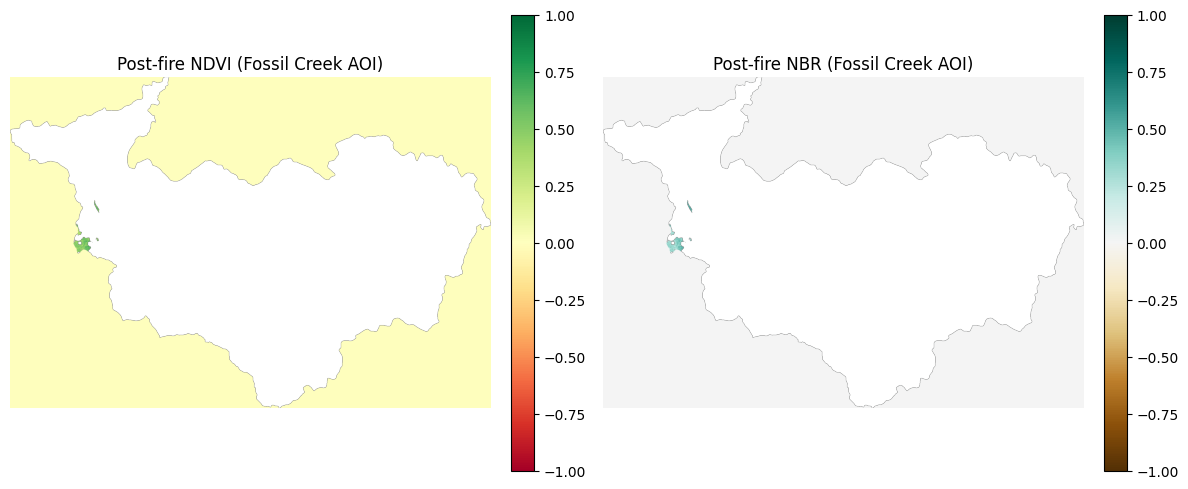

In [52]:
#creates side-by-side maps of post-fire NDVI and NBR over the AOI, 
#which is a visual QA check to confirm that the burn scar shows up as low NDVI and low/high-contrast NBR relative to the surrounding landscape.

ndvi_post_clipped = ndvi_post.copy()
nbr_post_clipped  = nbr_post.copy()

# Clip to [-1, 1] for visualization
ndvi_post_clipped = np.clip(ndvi_post_clipped, -1, 1)
nbr_post_clipped  = np.clip(nbr_post_clipped,  -1, 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(ndvi_post_clipped, cmap="RdYlGn", vmin=-1, vmax=1)
axes[0].set_title("Post-fire NDVI (Fossil Creek AOI)")
axes[0].axis("off")
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(nbr_post_clipped, cmap="BrBG", vmin=-1, vmax=1)
axes[1].set_title("Post-fire NBR (Fossil Creek AOI)")
axes[1].axis("off")
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [53]:
#writes the post-fire NDVI and NBR arrays out as GeoTIFFs in data_processed, 
#using the Landsat geometry and CRS so you can bring them into QGIS/ArcGIS and use them later for dNBR and summary stats.

out_dir = Path("data_processed")
out_dir.mkdir(exist_ok=True)

# Start from the post-fire red band profile and update it for our derived rasters
post_profile = post_b4.profile.copy()
post_profile.update(
    driver="GTiff",
    height=ndvi_post.shape[0],
    width=ndvi_post.shape[1],
    transform=post_transform,
    count=1,
    dtype="float32",
    nodata=np.nan,
)

ndvi_post_path = out_dir / "FossilCreek_postfire_NDVI.tif"
nbr_post_path  = out_dir / "FossilCreek_postfire_NBR.tif"

with rasterio.open(ndvi_post_path, "w", **post_profile) as dst:
    dst.write(ndvi_post.astype("float32"), 1)

with rasterio.open(nbr_post_path, "w", **post_profile) as dst:
    dst.write(nbr_post.astype("float32"), 1)

print("Saved post-fire NDVI to:", ndvi_post_path)
print("Saved post-fire NBR to:",  nbr_post_path)


Saved post-fire NDVI to: data_processed\FossilCreek_postfire_NDVI.tif
Saved post-fire NBR to: data_processed\FossilCreek_postfire_NBR.tif


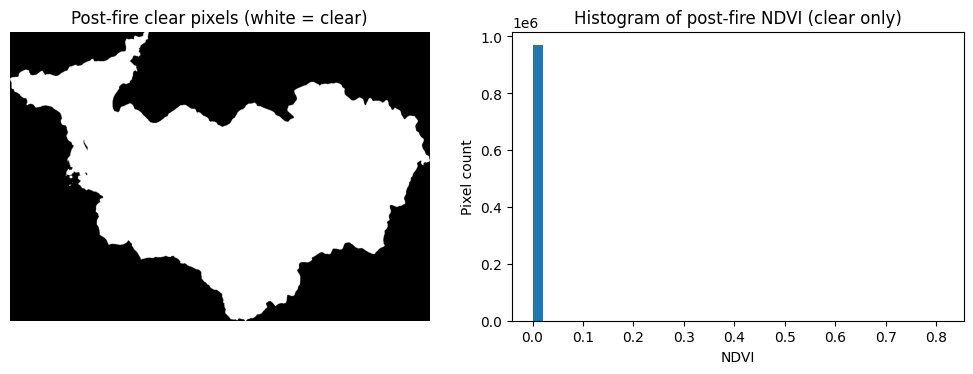

In [54]:
# This cell visualizes which parts of the AOI are flagged as clear by QA_PIXEL,
# so you can see whether clouds are the reason the post-fire NDVI/NBR look sparse.

mask_display = np.where(post_clear_mask, 1, np.nan)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].imshow(mask_display, cmap="Greys", vmin=0, vmax=1)
ax[0].set_title("Post-fire clear pixels (white = clear)")
ax[0].axis("off")

ax[1].hist(ndvi_post[post_clear_mask].ravel(), bins=40)
ax[1].set_title("Histogram of post-fire NDVI (clear only)")
ax[1].set_xlabel("NDVI")
ax[1].set_ylabel("Pixel count")

plt.tight_layout()
plt.show()
